In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import itertools
import hetio.readwrite
from plotnine import *

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import sys
sys.path.insert(0, '../')
from hetmech.degree_weight import dwpc
import hetmech.hetmat
from hetmech.matrix import metaedge_to_adjacency_matrix

# Implement DGP

In [3]:
repo_url = 'https://github.com/dhimmel/hetionet'
commit = '6d26d15e9055b33b4fd97a180fa288e4f2060b96'
names = ['hetionet-v1.0'] + [f'hetionet-v1.0-perm-{i + 1}' for i in range(5)]    
paths = ['hetnet/json/hetionet-v1.0.json.bz2'] + [
    f'hetnet/permuted/json/{name}.json.bz2' for name in names[1:]
]

In [4]:
metapaths = None
permuted = pd.DataFrame()
dwpc_df = pd.DataFrame()

for name, path in zip(names, paths):
    # Load from disk, if not found, load from url graph via hetio
    try:
        hetmat = hetmech.hetmat.HetMat(f'hetmat/{name}/')
    except FileNotFoundError:
        url = f'{repo_url}/raw/{commit}/{path}'
        graph = hetio.readwrite.read_graph(url)
        hetmech.hetmat.hetmat_from_graph(graph, f'hetmat/{name}/')
        hetmat = hetmech.hetmat.HetMat(f'hetmat/{name}/')
    print(f'Loaded {name}')
    
    if not metapaths:
        metapaths = hetmat.metagraph.extract_metapaths(
            source=hetmat.metagraph.get_metanode('C'), 
            target=hetmat.metagraph.get_metanode('D'), 
            max_length=2)
    for metapath in metapaths:
        c, d, dwpc_matrix, t = dwpc(hetmat, metapath)
        print(f'metapath: {metapath}, time: {t :.2f} sec')

        out_degrees = np.sum(metaedge_to_adjacency_matrix(hetmat, metapath[0], dense_threshold=0)[2], axis=1)
        in_degrees = np.sum(metaedge_to_adjacency_matrix(hetmat, metapath[-1], dense_threshold=0)[2], axis=0)
        degree_combos = list(itertools.product(out_degrees, in_degrees))
        indices = list(itertools.product(range(len(in_degrees)), range(len(out_degrees))))
        index_df = pd.DataFrame(indices, columns=['row', 'col'])
        degree_combo_df = pd.DataFrame(degree_combos, columns=['source_degree', 'target_degree'])
        degree_index_df = index_df.join(degree_combo_df)

        # Add DWPC values
        degree_index_df['dwpc'] = dwpc_matrix.reshape(np.prod(dwpc_matrix.shape))
        degree_index_df['metapath'] = str(metapath) # String because can't group by objects in Pandas
        degree_index_df.drop(columns=['row', 'col'])
        if 'perm' in name:
            permuted = permuted.append(degree_index_df)
        else:
            dwpc_df = dwpc_df.append(degree_index_df)

Loaded hetionet-v1.0
metapath: CtD, time: 0.02 sec
metapath: CpD, time: 0.01 sec
metapath: CbGaD, time: 1.53 sec
metapath: CbGuD, time: 1.51 sec
metapath: CbGdD, time: 1.50 sec
metapath: CrCtD, time: 0.14 sec
metapath: CrCpD, time: 0.13 sec
metapath: CdGaD, time: 1.57 sec
metapath: CdGuD, time: 1.59 sec
metapath: CdGdD, time: 1.40 sec
metapath: CtDrD, time: 0.01 sec
metapath: CuGaD, time: 1.37 sec
metapath: CuGuD, time: 1.36 sec
metapath: CuGdD, time: 1.55 sec
metapath: CpDrD, time: 0.02 sec
Loaded hetionet-v1.0-perm-1
metapath: CtD, time: 0.02 sec
metapath: CpD, time: 0.01 sec
metapath: CbGaD, time: 1.98 sec
metapath: CbGuD, time: 1.64 sec
metapath: CbGdD, time: 1.42 sec
metapath: CrCtD, time: 0.12 sec
metapath: CrCpD, time: 0.12 sec
metapath: CdGaD, time: 1.37 sec
metapath: CdGuD, time: 1.38 sec
metapath: CdGdD, time: 1.37 sec
metapath: CtDrD, time: 0.01 sec
metapath: CuGaD, time: 1.40 sec
metapath: CuGuD, time: 1.67 sec
metapath: CuGdD, time: 1.48 sec
metapath: CpDrD, time: 0.01 sec

In [5]:
# Remove zero-degree elements. Increases computation speed without loss of useful information
permuted = permuted[(permuted['source_degree'] != 0) & (permuted['target_degree'] != 0)]

In [6]:
degree_grouped_permutations = (permuted
                               .groupby(['source_degree', 'target_degree', 'metapath'])['dwpc']
                               .apply(list).reset_index())
dwpc_scaler = dwpc_df['dwpc'].mean()
dwpc_df['dwpc'] = np.arcsinh(dwpc_df['dwpc'] / dwpc_scaler)
degree_grouped_permutations['num-perm'] = degree_grouped_permutations['dwpc'].apply(len)
degree_grouped_permutations['p-dwpc'] = (degree_grouped_permutations['dwpc']
                                         .apply(lambda x: np.mean(np.arcsinh(np.array(x) / dwpc_scaler))))
degree_grouped_permutations['sd-dwpc'] = degree_grouped_permutations['dwpc'].apply(np.std)

In [7]:
full_dwpc_df = (dwpc_df
                .merge(degree_grouped_permutations, on=['source_degree', 'target_degree', 'metapath'])
                .rename(columns={'dwpc_x': 'dwpc', 'dwpc_y': 'permutations'}))

In [8]:
full_dwpc_df['r-dwpc'] = full_dwpc_df['dwpc'] - full_dwpc_df['p-dwpc']
full_dwpc_df['z-dwpc'] = full_dwpc_df['r-dwpc'] / full_dwpc_df['sd-dwpc']

In [9]:
full_dwpc_df['z-dwpc'] = full_dwpc_df['z-dwpc'].apply(lambda x: 0 if x == - np.inf else x)

In [10]:
full_dwpc_df.head(2)

,row,col,source_degree,target_degree,dwpc,metapath,permutations,num-perm,p-dwpc,sd-dwpc,r-dwpc,z-dwpc
0,0,2,2,4,0.0,CtD,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2485,0.087684,0.037317,-0.087684,-2.3497
1,0,12,2,4,0.0,CtD,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2485,0.087684,0.037317,-0.087684,-2.3497


# Query start and end node

In [11]:
def two_node_query(source_index, target_index, dataframe, z_threshold=None):
    df = (dataframe[(dataframe['row'] == source_index) & (dataframe['col'] == target_index)]
         .sort_values(by='z-dwpc', ascending=False))
    df = df[['row', 'col', 'metapath', 'dwpc', 'z-dwpc']]

    if z_threshold is not None:
        df = df[df['z-dwpc'] >= z_threshold]

    return df

In [12]:
two_node_query(26, 768, full_dwpc_df, z_threshold=0)

,row,col,metapath,dwpc,z-dwpc
903269,26,768,CpDrD,5.142973,421.932488


## Check to see if we could interpolate P-DWPC based on surroundings

In [50]:
metapaths

[CtD,
 CpD,
 CbGaD,
 CbGuD,
 CbGdD,
 CrCtD,
 CrCpD,
 CdGaD,
 CdGuD,
 CdGdD,
 CtDrD,
 CuGaD,
 CuGuD,
 CuGdD,
 CpDrD]

In [71]:
metapath = 'CtDrD'

In [72]:
mean_p_dwpc = full_dwpc_df.groupby(['source_degree', 'target_degree', 'metapath'])['p-dwpc'].apply(np.mean).reset_index()
mean_p_dwpc = mean_p_dwpc[mean_p_dwpc['metapath'] == metapath]

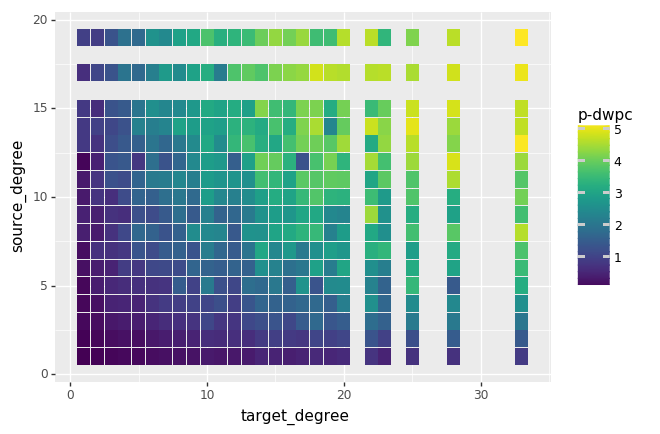

<ggplot: (8787790580558)>

In [73]:
(ggplot(mean_p_dwpc, aes('target_degree', 'source_degree', fill='p-dwpc'))
+ geom_tile(aes(width=.95, height=.95)))

In [74]:
num_df = full_dwpc_df[full_dwpc_df['metapath'] == metapath][['source_degree', 'target_degree', 'num-perm']]
num_df = num_df.groupby(['source_degree', 'target_degree'])['num-perm'].apply(lambda x: list(x)[0]).reset_index()

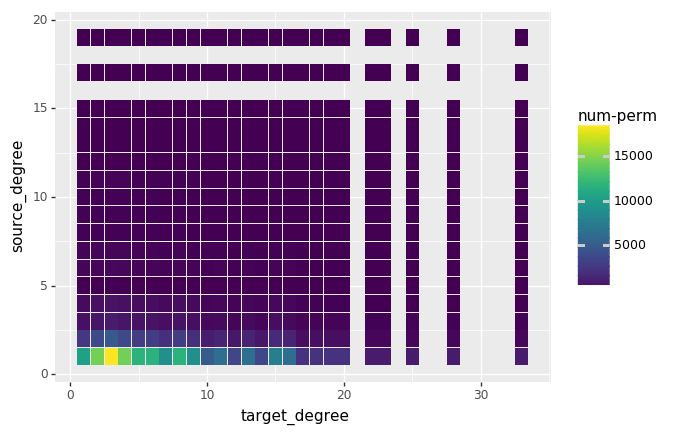

<ggplot: (8787789348388)>

In [75]:
(ggplot(num_df, aes('target_degree', 'source_degree', fill='num-perm'))
+ geom_tile(aes(width=.95, height=.95)))